In [2]:
import pandas as pd
from sodapy import Socrata
import seaborn as sns

#aqui sacamos las tablas de datos de hospitales y desfibriladores 
client = Socrata("analisi.transparenciacatalunya.cat", None)

desfibriladors = client.get("wpud-ukyg")
hospitales = client.get("8gmd-gz7i")


df_socioeconomic = pd.read_csv("socio_eco.csv")

In [3]:

#CÓDIGO QUE LIMPIA Y PROCESA LOS DATOS SOCIOECONÓMICOS Y CENSO, DEJA UNA COLUMNA DE PUNTUACIÓN SOCIOECONÓMICA QUE USARÉ PARA EL MAPA
df_cens=pd.read_csv("cens.csv", sep=';')  # Saltar líneas problemáticas
df_cens.drop(columns=['estat', 'any', 'concepte','geo'], inplace=True)

df_cens = df_cens[~df_cens['edat'].str.contains('any', na=False)]
df_cens = df_cens[~df_cens['sexe'].str.contains('homes', na=False)]
df_cens= df_cens[~df_cens['sexe'].str.contains('dones', na=False)]
df_cens= df_cens[~df_cens['municipi'].str.contains('anys', na=False)]

df_cens.drop(columns=['edat', 'sexe'], inplace=True)

df_socioeconomic = pd.read_csv("socio_eco.csv")
df_socioeconomic = df_socioeconomic[['any', 'municipi', 'concepte', 'valor']]
# Limpiar valores vacíos o '..'
df_socioeconomic['valor'] = pd.to_numeric(df_socioeconomic['valor'], errors='coerce')

# Pivotar
df_socioeconomic = df_socioeconomic.pivot_table(
    index=['any', 'municipi'],
    columns='concepte',
    values='valor',
    aggfunc='first'
).reset_index()

# ahora sustituyo los valores NaN por la media de la columna
for column in df_socioeconomic.columns:
    if df_socioeconomic[column].dtype in ['float64', 'int64']:
        mean_value = df_socioeconomic[column].mean()
        df_socioeconomic[column].fillna(mean_value, inplace=True)

df_socioeconomic['població desocupada(%)'] = 100-df_socioeconomic['població ocupada (%)']
df_socioeconomic.drop(columns=['població ocupada (%)'], inplace=True)

#normalizo cada columna numérica sin sklearn
numeric_columns = df_socioeconomic.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    min_value = df_socioeconomic[column].min()
    max_value = df_socioeconomic[column].max()
    df_socioeconomic[column] = (df_socioeconomic[column] - min_value) / (max_value - min_value)
df_socioeconomic.drop(columns=['any'], inplace=True)
df_socioeconomic.drop(columns=['estrangers de països de renda baixa o mitjana (%)'], inplace=True)
#ahora creo una columna de puntuación de pobreza socioeconómica, que haga la media sumando o restando algunas columnas

df_socioeconomic['puntuació pobreza socioeconòmica'] = (
    df_socioeconomic['població amb estudis baixos (%)'] * (1/3) +
    df_socioeconomic['població jove sense estudis postobligatoris (%)'] * (1/6) -
    df_socioeconomic['renda mitjana per persona (€)'] * (1/3) +
    df_socioeconomic['treballadors de baixa qualificació (%)'] * (1/12) +
    df_socioeconomic['població desocupada(%)'] * (1/12)
)


C:\Users\German\AppData\Local\Temp\ipykernel_12628\1381535994.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens=pd.read_csv("cens.csv", sep=';')  # Saltar líneas problemáticas
C:\Users\German\AppData\Local\Temp\ipykernel_12628\1381535994.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_socioeconomic[column].fillna(mean_value, inplace=True)


Pesos del PCA:
població amb estudis baixos (%)                    0.476087
població jove sense estudis postobligatoris (%)    0.526400
treballadors de baixa qualificació (%)             0.306693
població desocupada(%)                             0.365872
renta_inv                                          0.517998
dtype: float64

Varianza explicada por la primera componente: 0.547710004148582


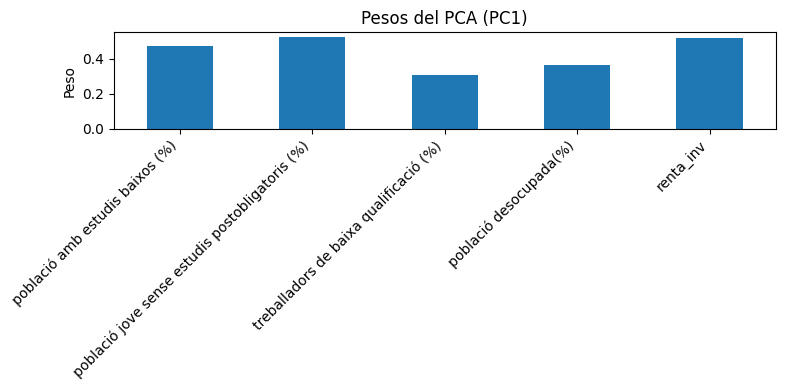

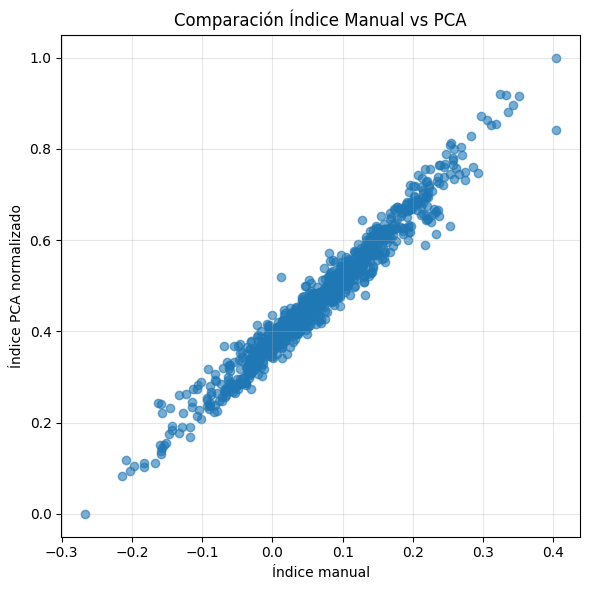

Correlación manual vs PCA = 0.9803282244785025


In [4]:
#PRUEBA DE PCA
# =========================
# GRÁFICOS DEL PCA Y COMPARACIÓN CON ÍNDICE MANUAL
# =========================

import matplotlib.pyplot as plt
# =========================
# PCA PARA ÍNDICE SOCIOECONÓMICO
# =========================
import sklearn as sk
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Variables que quieres incluir en el índice
vars_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renda mitjana per persona (€)'
]

# Invertir la renta normalizada para que mayor valor = mayor pobreza
df_socioeconomic['renta_inv'] = 1 - df_socioeconomic['renda mitjana per persona (€)']

# Preparar matriz X para el PCA
vars_for_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renta_inv'
]

X = df_socioeconomic[vars_for_pca].values

# Aplicar PCA con 1 componente
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X)

# Guardar la componente principal como índice bruto
df_socioeconomic['indice_pca_bruto'] = pc1[:, 0]

# Normalizar a rango [0,1]
idx = df_socioeconomic['indice_pca_bruto']
df_socioeconomic['indice_pca_norm'] = (idx - idx.min()) / (idx.max() - idx.min())

# Mostrar pesos del PCA
pesos_pca = pd.Series(pca.components_[0], index=vars_for_pca)
print("Pesos del PCA:")
print(pesos_pca)

# Varianza explicada
print("\nVarianza explicada por la primera componente:", pca.explained_variance_ratio_[0])

# --- 1. Gráfico de pesos del PCA ---
plt.figure(figsize=(8,4))
pesos_pca.plot(kind='bar')
plt.title("Pesos del PCA (PC1)")
plt.ylabel("Peso")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 2. Comparación del índice manual vs PCA ---
plt.figure(figsize=(6,6))
plt.scatter(
    df_socioeconomic['puntuació pobreza socioeconòmica'], 
    df_socioeconomic['indice_pca_norm'],
    alpha=0.6
)
plt.xlabel("Índice manual")
plt.ylabel("Índice PCA normalizado")
plt.title("Comparación Índice Manual vs PCA")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlación entre ambos índices
corr = df_socioeconomic['puntuació pobreza socioeconòmica'].corr(df_socioeconomic['indice_pca_norm'])
print("Correlación manual vs PCA =", corr)


In [5]:
df_socioeconomic 

concepte,municipi,població amb estudis baixos (%),població jove sense estudis postobligatoris (%),renda mitjana per persona (€),treballadors de baixa qualificació (%),població desocupada(%),puntuació pobreza socioeconòmica,renta_inv,indice_pca_bruto,indice_pca_norm
0,Abella de la Conca,0.449029,0.415039,0.254854,0.283945,0.445808,0.194711,0.745146,0.213786,0.629292
1,Abrera,0.305825,0.084956,0.510895,0.191136,0.278119,-0.015093,0.489105,-0.250592,0.301248
2,Agramunt,0.412621,0.433628,0.404639,0.390582,0.290389,0.131680,0.595361,0.104492,0.552085
3,Aguilar de Segarra,0.322816,0.415039,0.568501,0.283945,0.177914,0.025766,0.431499,-0.106785,0.402836
4,Agullana,0.337379,0.256637,0.707551,0.283945,0.321063,-0.030201,0.292449,-0.202888,0.334947
...,...,...,...,...,...,...,...,...,...,...
942,Viver i Serrateix,0.366505,0.415039,0.546980,0.283945,0.083845,0.039664,0.453020,-0.109255,0.401091
943,Xerta,0.398058,0.230088,0.344283,0.240997,0.546012,0.121857,0.655717,0.069328,0.527245
944,Àger,0.436893,0.260177,0.449191,0.283945,0.298569,0.087806,0.550809,-0.028047,0.458457
945,Òdena,0.347087,0.428319,0.432255,0.227147,0.292434,0.086296,0.567745,0.006816,0.483085


In [6]:
df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitales = pd.DataFrame.from_records(hospitales) 
#ahora voy a limpiar las tablas de hospitales y desfibriladores
df_desfibriladors = df_desfibriladors[['comarca', 'municipi']]
df_hospitales= df_hospitales[['poblacio','comarca']]

#4 TABLAS CONTANDO CUANTOS HOSPITALES Y DESFIBRILADORES HAY POR COMARCA Y MUNICIPIO
des_count_municipi = df_desfibriladors['municipi'].value_counts().reset_index()
des_count_comarca = df_desfibriladors['comarca'].value_counts().reset_index() 

hospi_count_municipi = df_hospitales['poblacio'].value_counts().reset_index()
hospi_count_comarca = df_hospitales['comarca'].value_counts().reset_index()

#hago un merge de las 2 tablas por municipio sumando los valores de hospitales y desfibriladores, por ejemplo
#para barcelona sumo los hospitales y desfibriladores para tener un numero total de recursos sanitarios
recursos_municipi = pd.merge(des_count_municipi, hospi_count_municipi, left_on='municipi', right_on='poblacio', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
#ahora sumo las dos columnas de recursos sanitarios en una sola
recursos_municipi['recursos_sanitaris_totals'] = recursos_municipi['count_desfibriladors'] + recursos_municipi['count_hospitals']

recursos_comarca = pd.merge(des_count_comarca, hospi_count_comarca, left_on='comarca', right_on='comarca', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
recursos_comarca['recursos_sanitaris_totals'] = recursos_comarca['count_desfibriladors'] + recursos_comarca['count_hospitals']





Percentil 96% de recursos per 1000 hab: 1.58
Comarques amb valors > p96 (capeades): Alta Ribagorça, Priorat


C:\Users\German\AppData\Local\Temp\ipykernel_12628\4191446636.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comarcas_recursos['recursos_per_1000_hab'].fillna(0, inplace=True)


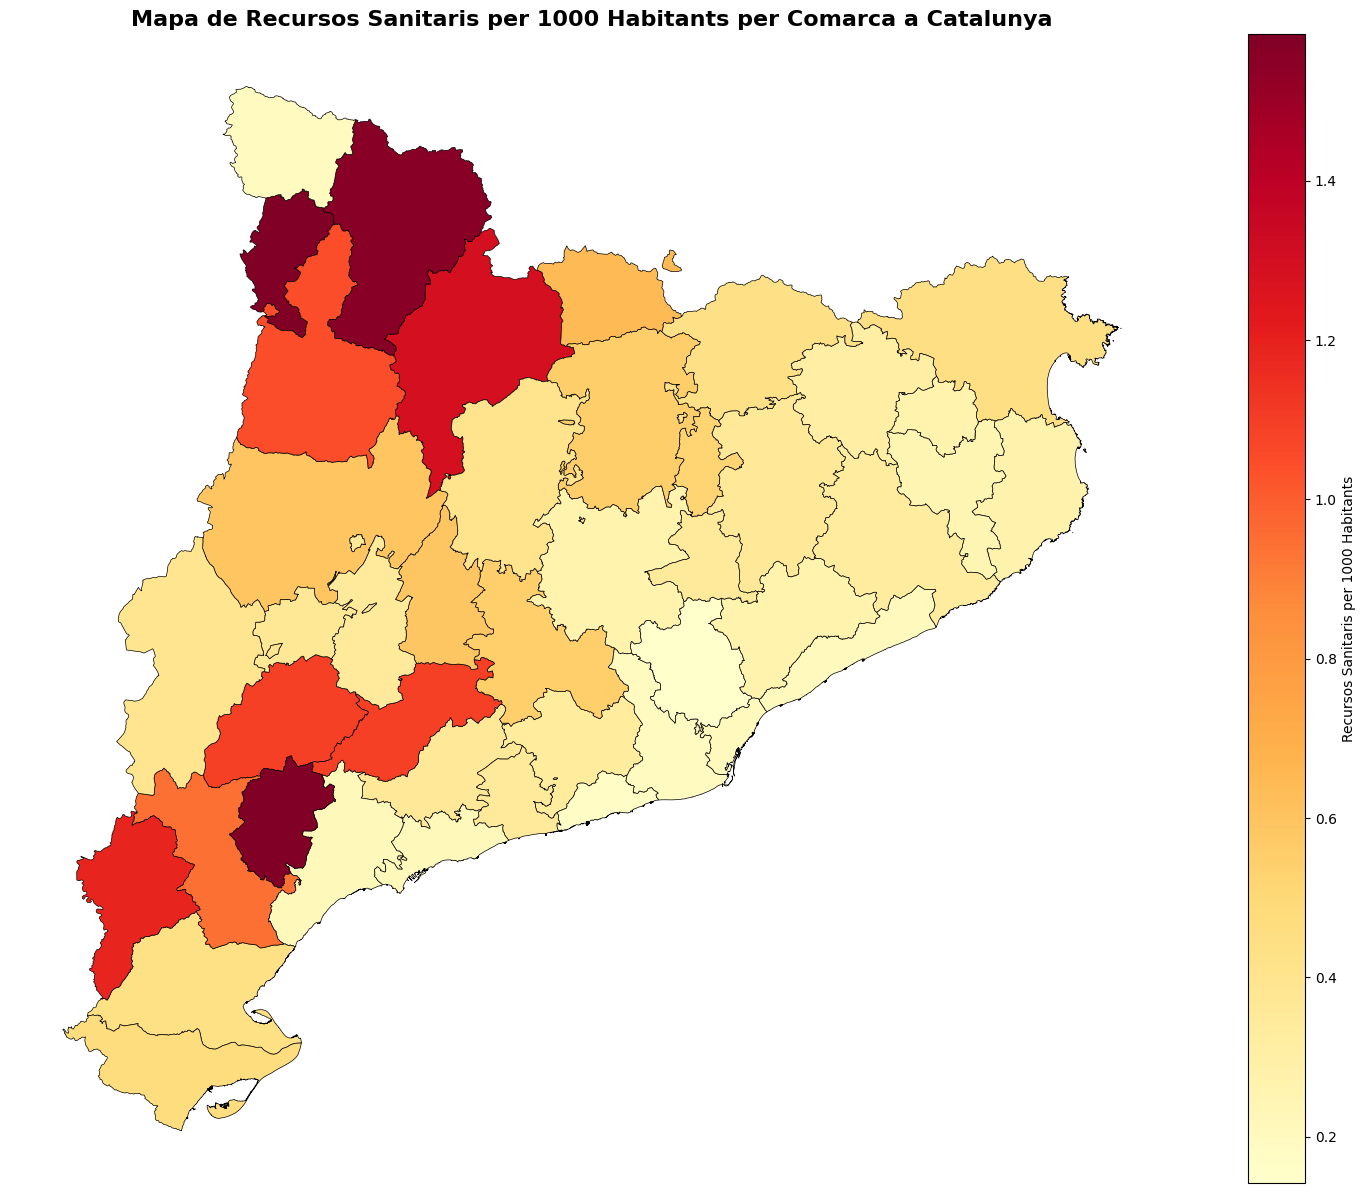

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = "carto/"

municipis_geo = gpd.read_file(data_dir + "muni.json")
comarcas = gpd.read_file(data_dir + "comarcas.json")

# Merge de df_cens con municipis para obtener la comarca de cada municipio
df_cens_comarca = df_cens.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                 left_on='municipi', 
                                 right_on='NOMMUNI', 
                                 how='left')

# Agrupar por comarca y sumar la población
poblacio_per_comarca = df_cens_comarca.groupby('NOMCOMAR')['valor'].sum().reset_index()
poblacio_per_comarca.columns = ['comarca', 'poblacio']

# Merge de recursos_comarca con población
recursos_comarca_poblacio = recursos_comarca.merge(poblacio_per_comarca, on='comarca', how='left')

# Calcular recursos por cada 1000 habitantes
recursos_comarca_poblacio['recursos_per_1000_hab'] = (recursos_comarca_poblacio['recursos_sanitaris_totals'] / recursos_comarca_poblacio['poblacio']) * 1000

# FILTRO DE OUTLIERS: Capear valores al percentil 96%
percentil_96 = recursos_comarca_poblacio['recursos_per_1000_hab'].quantile(0.96)
print(f"Percentil 96% de recursos per 1000 hab: {percentil_96:.2f}")

# Identificar outliers
comarcas_outliers = recursos_comarca_poblacio[recursos_comarca_poblacio['recursos_per_1000_hab'] > percentil_96]['comarca'].tolist()
if comarcas_outliers:
    print(f"Comarques amb valors > p96 (capeades): {', '.join(comarcas_outliers)}")

# Capear los valores al percentil 96 (no eliminar, solo limitar el valor máximo)
recursos_comarca_poblacio['recursos_per_1000_hab'] = recursos_comarca_poblacio['recursos_per_1000_hab'].clip(upper=percentil_96)

# Merge del mapa de comarcas con los datos de recursos por población
comarcas_recursos = comarcas.merge(recursos_comarca_poblacio, left_on='NOMCOMAR', right_on='comarca', how='left')

# Rellenar valores NaN con 0 (comarcas sin recursos)
comarcas_recursos['recursos_per_1000_hab'].fillna(0, inplace=True)

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

comarcas_recursos.plot(column='recursos_per_1000_hab', 
                        ax=ax, 
                        legend=True,
                        cmap='YlOrRd',
                        edgecolor='black',
                        linewidth=0.5,
                        legend_kwds={'label': "Recursos Sanitaris per 1000 Habitants",
                                     'orientation': "vertical"})

ax.set_title('Mapa de Recursos Sanitaris per 1000 Habitants per Comarca a Catalunya', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
df_socioeconomic

concepte,municipi,població amb estudis baixos (%),població jove sense estudis postobligatoris (%),renda mitjana per persona (€),treballadors de baixa qualificació (%),població desocupada(%),puntuació pobreza socioeconòmica,renta_inv,indice_pca_bruto,indice_pca_norm
0,Abella de la Conca,0.449029,0.415039,0.254854,0.283945,0.445808,0.194711,0.745146,0.213786,0.629292
1,Abrera,0.305825,0.084956,0.510895,0.191136,0.278119,-0.015093,0.489105,-0.250592,0.301248
2,Agramunt,0.412621,0.433628,0.404639,0.390582,0.290389,0.131680,0.595361,0.104492,0.552085
3,Aguilar de Segarra,0.322816,0.415039,0.568501,0.283945,0.177914,0.025766,0.431499,-0.106785,0.402836
4,Agullana,0.337379,0.256637,0.707551,0.283945,0.321063,-0.030201,0.292449,-0.202888,0.334947
...,...,...,...,...,...,...,...,...,...,...
942,Viver i Serrateix,0.366505,0.415039,0.546980,0.283945,0.083845,0.039664,0.453020,-0.109255,0.401091
943,Xerta,0.398058,0.230088,0.344283,0.240997,0.546012,0.121857,0.655717,0.069328,0.527245
944,Àger,0.436893,0.260177,0.449191,0.283945,0.298569,0.087806,0.550809,-0.028047,0.458457
945,Òdena,0.347087,0.428319,0.432255,0.227147,0.292434,0.086296,0.567745,0.006816,0.483085


C:\Users\German\AppData\Local\Temp\ipykernel_12628\2698180758.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comarcas_pobreza['puntuacio_pobreza'].fillna(0, inplace=True)


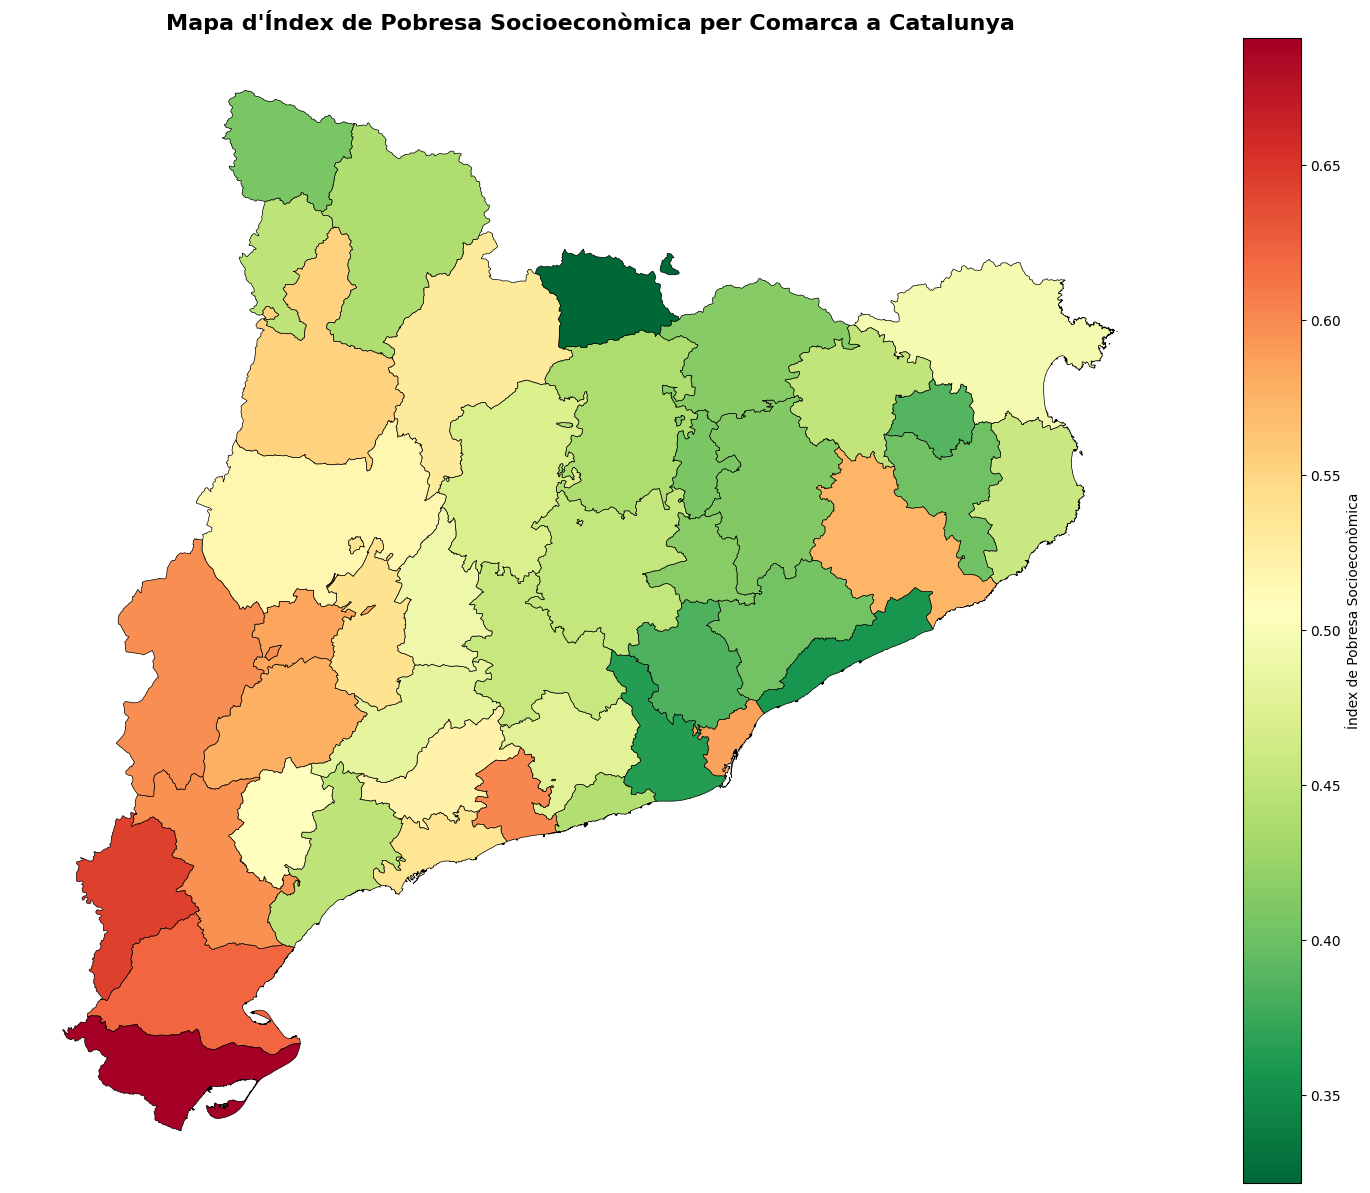

In [9]:
# Merge de df_socioeconomic con municipis_geo para obtener la comarca de cada municipio
df_socioeconomic_comarca = df_socioeconomic.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                                    left_on='municipi', 
                                                    right_on='NOMMUNI', 
                                                    how='left')

# Calcular la media de la puntuación de pobreza socioeconómica por comarca
pobreza_per_comarca = df_socioeconomic_comarca.groupby('NOMCOMAR')['indice_pca_norm'].mean().reset_index()
pobreza_per_comarca.columns = ['comarca', 'puntuacio_pobreza']

# Merge del mapa de comarcas con los datos de pobreza socioeconómica
comarcas_pobreza = comarcas.merge(pobreza_per_comarca, left_on='NOMCOMAR', right_on='comarca', how='left')

# Rellenar valores NaN con 0 (comarcas sin datos)
comarcas_pobreza['puntuacio_pobreza'].fillna(0, inplace=True)

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

comarcas_pobreza.plot(column='puntuacio_pobreza', 
                       ax=ax, 
                       legend=True,
                       cmap='RdYlGn_r',  # Rojo = más pobreza, Verde = menos pobreza
                       edgecolor='black',
                       linewidth=0.5,
                       legend_kwds={'label': "Índex de Pobresa Socioeconòmica",
                                    'orientation': "vertical"})

ax.set_title('Mapa d\'Índex de Pobresa Socioeconòmica per Comarca a Catalunya', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()


Percentil 95% de recursos per 1000 hab: 1.31
Comarcas antes del filtro: 43
Comarcas después del filtro: 40
Comarcas eliminadas: 3

Comarques eliminades (outliers): Alta Ribagorça, Pallars Sobirà, Priorat


C:\Users\German\AppData\Local\Temp\ipykernel_12628\608093853.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


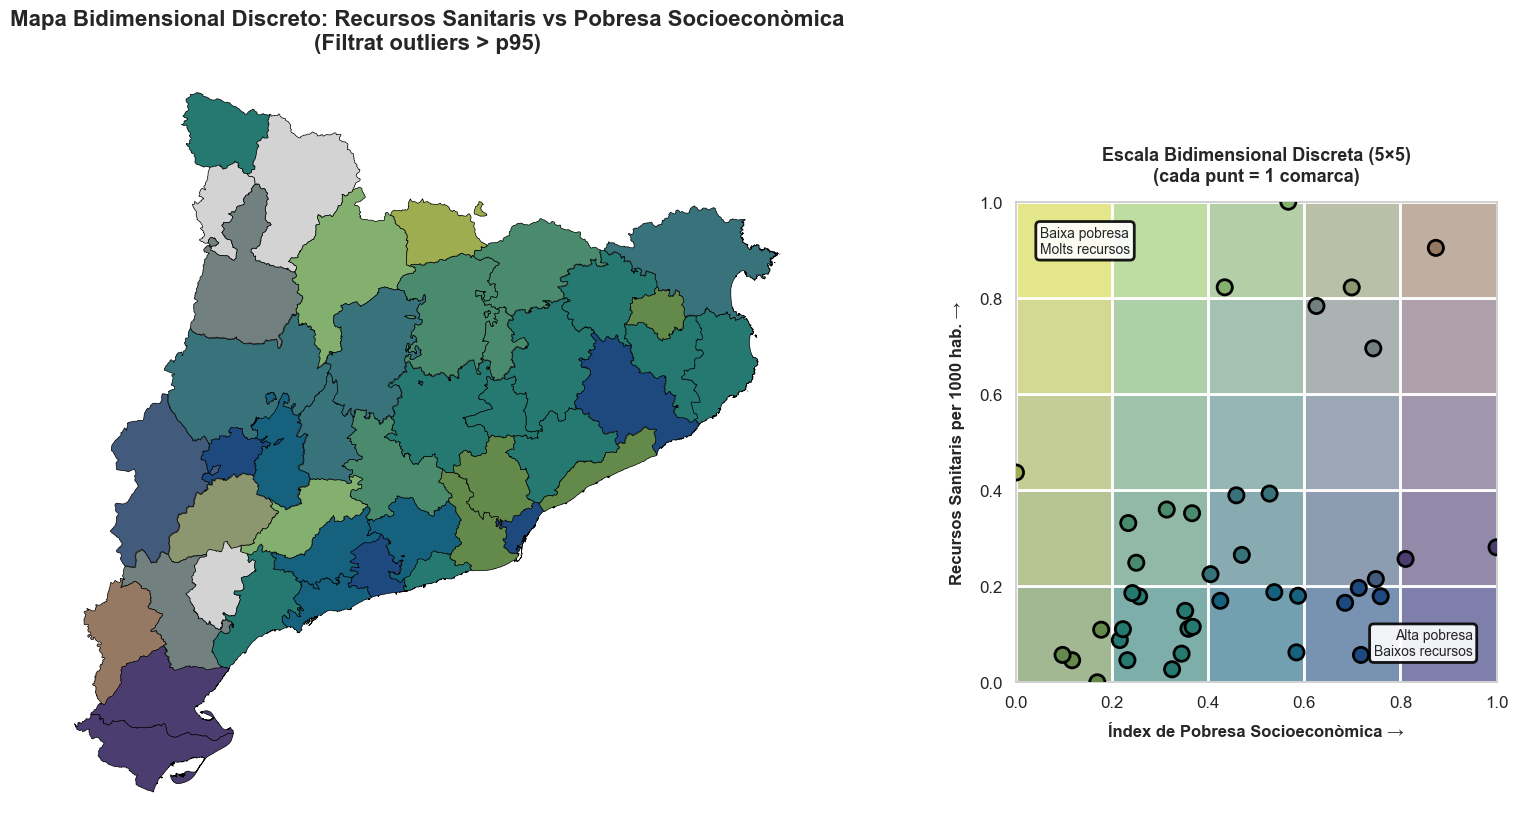


RESUM DESPRÉS DEL FILTRE D'OUTLIERS (Percentil 95%)
Total de comarques representades: 40
Nombre de categories per dimensió: 5
Total de combinacions de color: 25
Rang de recursos (filtrat): 0.14 - 1.30 per 1000 hab.

Interpretació (EJES TRANSPUESTOS):
- Cada punt representa una comarca en la seva posició exacta
- Els cuadrats de colors representen les categories discretes
- Eix X: Índex de pobresa socioeconòmica (esquerra=baixa, dreta=alta)
- Eix Y: Recursos sanitaris per 1000 habitants (baix=pocs, alt=molts)
- S'han eliminat comarques amb recursos > percentil 95% (outliers)


In [10]:
# Merge de los dos DataFrames de recursos y pobreza
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
import colorcet as cc

# Configurar estilo de seaborn
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

datos_combinados = recursos_comarca_poblacio.merge(pobreza_per_comarca, on='comarca', how='inner')

# FILTRO DE OUTLIERS: Eliminar comarcas con recursos fuera del percentil 95%
percentil_95 = datos_combinados['recursos_per_1000_hab'].quantile(0.93)
print(f"Percentil 95% de recursos per 1000 hab: {percentil_95:.2f}")
print(f"Comarcas antes del filtro: {len(datos_combinados)}")

# Filtrar outliers (mantener solo comarcas <= percentil 95%)
datos_combinados_filtrados = datos_combinados[datos_combinados['recursos_per_1000_hab'] <= percentil_95].copy()
print(f"Comarcas después del filtro: {len(datos_combinados_filtrados)}")
print(f"Comarcas eliminadas: {len(datos_combinados) - len(datos_combinados_filtrados)}")

# Mostrar comarcas eliminadas
comarcas_eliminadas = datos_combinados[datos_combinados['recursos_per_1000_hab'] > percentil_95]['comarca'].tolist()
if comarcas_eliminadas:
    print(f"\nComarques eliminades (outliers): {', '.join(comarcas_eliminadas)}")

# Usar los datos filtrados para el resto del análisis
datos_combinados = datos_combinados_filtrados

# Normalizar ambos índices entre 0 y 1 manualmente
min_recursos = datos_combinados['recursos_per_1000_hab'].min()
max_recursos = datos_combinados['recursos_per_1000_hab'].max()
datos_combinados['recursos_norm'] = (datos_combinados['recursos_per_1000_hab'] - min_recursos) / (max_recursos - min_recursos)

min_pobreza = datos_combinados['puntuacio_pobreza'].min()
max_pobreza = datos_combinados['puntuacio_pobreza'].max()
datos_combinados['pobreza_norm'] = (datos_combinados['puntuacio_pobreza'] - min_pobreza) / (max_pobreza - min_pobreza)

# DISCRETIZAR los valores en n_bins categorías
n_bins = 5

# Asignar cada valor a un bin discreto (0 a n_bins-1)
datos_combinados['recursos_bin'] = np.floor(datos_combinados['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_combinados['pobreza_bin'] = np.floor(datos_combinados['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)

# MAPAS DE COLOR usando paletas de seaborn
cmap_pobreza = sns.color_palette("viridis_r", as_cmap=True)  # Eje X: pobreza
cmap_recursos = sns.color_palette("cividis", as_cmap=True)  # Eje Y: recursos

#cmap_pobreza = sns.color_palette("RdYlGn_r", as_cmap=True)  # Eje X: pobreza
#cmap_recursos = sns.color_palette("binary_r", as_cmap=True

# Calcular el color discreto para cada bin (TRANSPUESTO: pobreza_bin en X, recursos_bin en Y)
def get_discrete_color(pobreza_bin, recursos_bin, n_bins):
    # Convertir bin a valor normalizado (centro del bin)
    pobreza_val = (pobreza_bin + 0.5) / n_bins
    recursos_val = (recursos_bin + 0.5) / n_bins
    
    col_pob = cmap_pobreza(pobreza_val)[:3]
    col_rec = cmap_recursos(recursos_val)[:3]
    
    return [(col_pob[0] + col_rec[0])/2,
            (col_pob[1] + col_rec[1])/2,
            (col_pob[2] + col_rec[2])/2]

# Aplicar colores discretos a cada comarca (TRANSPUESTO)
datos_combinados['color_rgb'] = datos_combinados.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), 
    axis=1
)

# Merge con el mapa de comarcas
comarcas_combinado = comarcas.merge(datos_combinados, left_on='NOMCOMAR', right_on='comarca', how='left')

# Crear figura con dos subplots usando estilo seaborn
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.15)

# Subplot para el mapa
ax_map = fig.add_subplot(gs[0])

# Plotear con los colores RGB personalizados - SOLUCIÓN AL ERROR
# Separar comarcas con y sin datos
comarcas_con_color = comarcas_combinado[comarcas_combinado['color_rgb'].notna()].copy()
comarcas_sin_color = comarcas_combinado[comarcas_combinado['color_rgb'].isna()]

# Plotear comarcas sin datos en gris claro
if len(comarcas_sin_color) > 0:
    comarcas_sin_color.plot(ax=ax_map, color='lightgray', edgecolor='black', linewidth=0.5)

# Plotear cada comarca individualmente con su color (evita el error de array inhomogéneo)
for idx, row in comarcas_con_color.iterrows():
    comarcas_con_color.loc[[idx]].plot(
        ax=ax_map, 
        color=[row['color_rgb']],
        edgecolor='black',
        linewidth=0.5
    )

ax_map.set_title('Mapa Bidimensional Discreto: Recursos Sanitaris vs Pobresa Socioeconòmica\n(Filtrat outliers > p95)', 
                 fontsize=16, fontweight='bold')
ax_map.axis('off')

# Subplot para la leyenda bidimensional usando seaborn
ax_legend = fig.add_subplot(gs[1])

# PRIMERO: Crear la cuadrícula DISCRETA de colores de fondo (TRANSPUESTO)
for i in range(n_bins):  # i = pobreza (ahora en X)
    for j in range(n_bins):  # j = recursos (ahora en Y)
        # Calcular el color discreto para este cuadrado (TRANSPUESTO)
        color = get_discrete_color(i, j, n_bins)
        
        # Dibujar el cuadrado
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, 
                         edgecolor='white', 
                         linewidth=2,
                         alpha=0.6,
                         zorder=1)
        ax_legend.add_patch(rect)

# Añadir líneas de la cuadrícula para separar los bins
for i in range(n_bins + 1):
    ax_legend.axhline(i/n_bins, color='white', linewidth=2, alpha=0.9, zorder=2)
    ax_legend.axvline(i/n_bins, color='white', linewidth=2, alpha=0.9, zorder=2)

# DESPUÉS: Plotear cada comarca como un punto usando seaborn scatterplot
sns.scatterplot(
    data=datos_combinados,
    x='pobreza_norm',   # Eje X: Pobreza
    y='recursos_norm',  # Eje Y: Recursos
    s=120,
    edgecolor='black',
    linewidth=2,
    color='gray',  # Color base, luego lo sobrescribimos
    alpha=1.0,
    zorder=10,  # Encima de los cuadrados
    ax=ax_legend,
    legend=False
)

# Sobrescribir colores manualmente después de crear el scatter
scatter_points = ax_legend.collections[0]
scatter_points.set_facecolors(list(datos_combinados['color_rgb']))

# Configurar ejes - FORZAR ASPECTO CUADRADO
ax_legend.set_xlim(0, 1)
ax_legend.set_ylim(0, 1)
ax_legend.set_aspect('equal', adjustable='box')

# ETIQUETAS TRANSPUESTAS
ax_legend.set_xlabel('Índex de Pobresa Socioeconòmica →', fontsize=12, fontweight='bold', labelpad=10)
ax_legend.set_ylabel('Recursos Sanitaris per 1000 hab. →', fontsize=12, fontweight='bold', labelpad=10)
ax_legend.set_title(f'Escala Bidimensional Discreta ({n_bins}×{n_bins})\n(cada punt = 1 comarca)', 
                    fontsize=13, fontweight='bold', pad=15)

# Añadir anotaciones en las esquinas (TRANSPUESTAS)
ax_legend.text(0.05, 0.95, 'Baixa pobresa\nMolts recursos', 
               fontsize=10, ha='left', va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))
ax_legend.text(0.95, 0.05, 'Alta pobresa\nBaixos recursos', 
               fontsize=10, ha='right', va='bottom',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))

# Remover grid de seaborn para el scatter plot
ax_legend.grid(False)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"RESUM DESPRÉS DEL FILTRE D'OUTLIERS (Percentil 95%)")
print(f"{'='*60}")
print(f"Total de comarques representades: {len(datos_combinados)}")
print(f"Nombre de categories per dimensió: {n_bins}")
print(f"Total de combinacions de color: {n_bins * n_bins}")
print(f"Rang de recursos (filtrat): {min_recursos:.2f} - {max_recursos:.2f} per 1000 hab.")
print("\nInterpretació (EJES TRANSPUESTOS):")
print("- Cada punt representa una comarca en la seva posició exacta")
print("- Els cuadrats de colors representen les categories discretes")
print("- Eix X: Índex de pobresa socioeconòmica (esquerra=baixa, dreta=alta)")
print("- Eix Y: Recursos sanitaris per 1000 habitants (baix=pocs, alt=molts)")
print("- S'han eliminat comarques amb recursos > percentil 95% (outliers)")


In [11]:
#hay que analizar bien el plot de la derecha. tengo que revisar bien la normalización que he hecho, y una vez lo tenga, intentar
#hacer una division entre region con y sin puntos

In [12]:
df_socioeconomic

concepte,municipi,població amb estudis baixos (%),població jove sense estudis postobligatoris (%),renda mitjana per persona (€),treballadors de baixa qualificació (%),població desocupada(%),puntuació pobreza socioeconòmica,renta_inv,indice_pca_bruto,indice_pca_norm
0,Abella de la Conca,0.449029,0.415039,0.254854,0.283945,0.445808,0.194711,0.745146,0.213786,0.629292
1,Abrera,0.305825,0.084956,0.510895,0.191136,0.278119,-0.015093,0.489105,-0.250592,0.301248
2,Agramunt,0.412621,0.433628,0.404639,0.390582,0.290389,0.131680,0.595361,0.104492,0.552085
3,Aguilar de Segarra,0.322816,0.415039,0.568501,0.283945,0.177914,0.025766,0.431499,-0.106785,0.402836
4,Agullana,0.337379,0.256637,0.707551,0.283945,0.321063,-0.030201,0.292449,-0.202888,0.334947
...,...,...,...,...,...,...,...,...,...,...
942,Viver i Serrateix,0.366505,0.415039,0.546980,0.283945,0.083845,0.039664,0.453020,-0.109255,0.401091
943,Xerta,0.398058,0.230088,0.344283,0.240997,0.546012,0.121857,0.655717,0.069328,0.527245
944,Àger,0.436893,0.260177,0.449191,0.283945,0.298569,0.087806,0.550809,-0.028047,0.458457
945,Òdena,0.347087,0.428319,0.432255,0.227147,0.292434,0.086296,0.567745,0.006816,0.483085


Percentil 95% de recursos per 1000 hab: 1.58
Comarcas antes del filtro: 43
Comarcas después del filtro: 43
Comarcas eliminadas: 0


C:\Users\German\AppData\Local\Temp\ipykernel_12628\1605214654.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


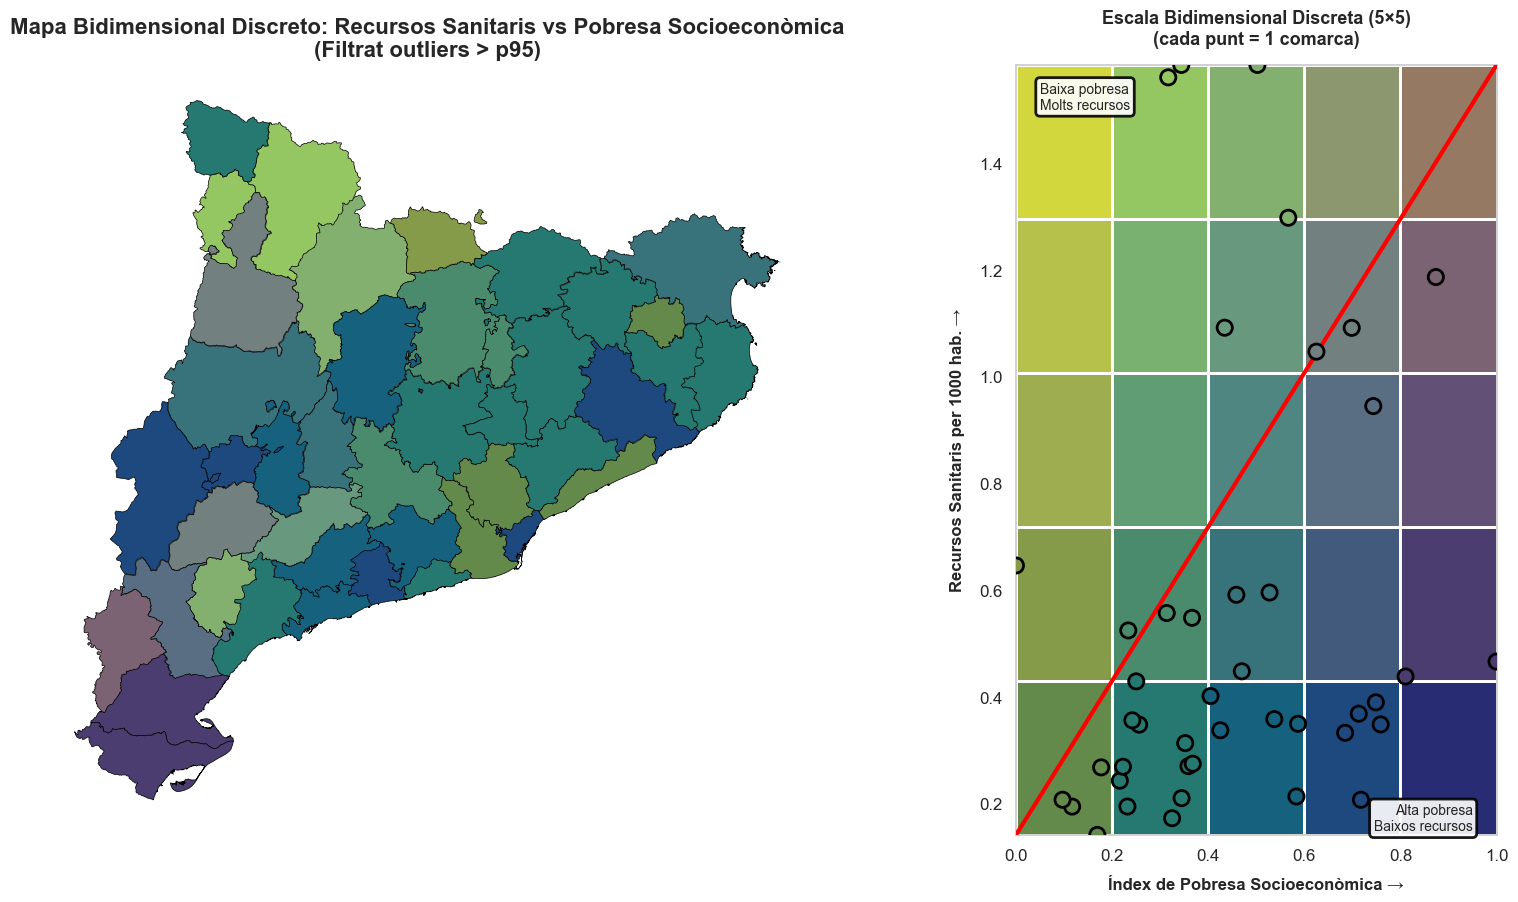


RESUM DESPRÉS DEL FILTRE D'OUTLIERS (Percentil 95%)
Total de comarques representades: 43
Nombre de categories per dimensió: 5
Total de combinacions de color: 25
Rang de recursos (sense normalitzar): 0.14 - 1.58 per 1000 hab.

Interpretació (EJES TRANSPUESTOS):
- Cada punt representa una comarca en la seva posició exacta
- Els cuadrats de colors representen les categories discretes
- Eix X: Índex de pobresa socioeconòmica normalitzat (0=baixa, 1=alta)
- Eix Y: Recursos sanitaris per 1000 habitants (valors reals sense normalitzar)
- Línia vermella diagonal: separa regions amb diferents relacions pobreza/recursos
- Cada quadrat del fons té el mateix color que les comarques corresponents
- S'han eliminat comarques amb recursos > percentil 95% (outliers)


In [13]:
#===========================================================================================================================
#==============================================SEGUNDA VERSIÓN==============================================================
# Merge de los dos DataFrames de recursos y pobreza
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
import colorcet as cc

# Configurar estilo de seaborn
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

datos_combinados = recursos_comarca_poblacio.merge(pobreza_per_comarca, on='comarca', how='inner')

# FILTRO DE OUTLIERS: Eliminar comarcas con recursos fuera del percentil 95%
percentil_95 = datos_combinados['recursos_per_1000_hab'].quantile(0.99)
print(f"Percentil 95% de recursos per 1000 hab: {percentil_95:.2f}")
print(f"Comarcas antes del filtro: {len(datos_combinados)}")

# Filtrar outliers (mantener solo comarcas <= percentil 95%)
datos_combinados_filtrados = datos_combinados[datos_combinados['recursos_per_1000_hab'] <= percentil_95].copy()
print(f"Comarcas después del filtro: {len(datos_combinados_filtrados)}")
print(f"Comarcas eliminadas: {len(datos_combinados) - len(datos_combinados_filtrados)}")

# Mostrar comarcas eliminadas
comarcas_eliminadas = datos_combinados[datos_combinados['recursos_per_1000_hab'] > percentil_95]['comarca'].tolist()
if comarcas_eliminadas:
    print(f"\nComarques eliminades (outliers): {', '.join(comarcas_eliminadas)}")

# Usar los datos filtrados para el resto del análisis
datos_combinados = datos_combinados_filtrados

# Normalizar solo el índice de pobreza entre 0 y 1
min_pobreza = datos_combinados['puntuacio_pobreza'].min()
max_pobreza = datos_combinados['puntuacio_pobreza'].max()
datos_combinados['pobreza_norm'] = (datos_combinados['puntuacio_pobreza'] - min_pobreza) / (max_pobreza - min_pobreza)

# Mantener recursos sin normalizar
datos_combinados['recursos_sin_norm'] = datos_combinados['recursos_per_1000_hab']

# Valores mínimos y máximos de recursos (sin normalizar)
min_recursos = datos_combinados['recursos_sin_norm'].min()
max_recursos = datos_combinados['recursos_sin_norm'].max()

# DISCRETIZAR los valores en n_bins categorías
n_bins = 5

# Para pobreza: usar valores normalizados [0,1]
datos_combinados['pobreza_bin'] = np.floor(datos_combinados['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)

# Para recursos: discretizar basándose en el rango real [min_recursos, max_recursos]
datos_combinados['recursos_bin'] = np.floor(
    (datos_combinados['recursos_sin_norm'] - min_recursos) / (max_recursos - min_recursos) * n_bins
).clip(0, n_bins-1).astype(int)

# MAPAS DE COLOR usando matplotlib directamente
from matplotlib.colors import LinearSegmentedColormap

# Crear colormaps manualmente
colors_pobreza = plt.cm.viridis_r(np.linspace(0, 1, 256))
cmap_pobreza = LinearSegmentedColormap.from_list('pobreza', colors_pobreza)

colors_recursos = plt.cm.cividis(np.linspace(0, 1, 256))
cmap_recursos = LinearSegmentedColormap.from_list('recursos', colors_recursos)

# Calcular el color discreto para cada bin (TRANSPUESTO: pobreza_bin en X, recursos_bin en Y)
def get_discrete_color(pobreza_bin, recursos_bin, n_bins):
    # Convertir bin a valor normalizado (centro del bin)
    pobreza_val = (pobreza_bin + 0.5) / n_bins
    recursos_val = (recursos_bin + 0.5) / n_bins
    
    col_pob = cmap_pobreza(pobreza_val)[:3]
    col_rec = cmap_recursos(recursos_val)[:3]
    
    return [(col_pob[0] + col_rec[0])/2,
            (col_pob[1] + col_rec[1])/2,
            (col_pob[2] + col_rec[2])/2]

# Aplicar colores discretos a cada comarca (TRANSPUESTO)
datos_combinados['color_rgb'] = datos_combinados.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), 
    axis=1
)

# Merge con el mapa de comarcas
comarcas_combinado = comarcas.merge(datos_combinados, left_on='NOMCOMAR', right_on='comarca', how='left')

# Crear figura con dos subplots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.15)

# Subplot para el mapa
ax_map = fig.add_subplot(gs[0])

# Plotear con los colores RGB personalizados
# Separar comarcas con y sin datos
comarcas_con_color = comarcas_combinado[comarcas_combinado['color_rgb'].notna()].copy()
comarcas_sin_color = comarcas_combinado[comarcas_combinado['color_rgb'].isna()]

# Plotear comarcas sin datos en gris claro
if len(comarcas_sin_color) > 0:
    comarcas_sin_color.plot(ax=ax_map, color='lightgray', edgecolor='black', linewidth=0.5)

# Plotear cada comarca individualmente con su color
for idx, row in comarcas_con_color.iterrows():
    comarcas_con_color.loc[[idx]].plot(
        ax=ax_map, 
        color=[row['color_rgb']],
        edgecolor='black',
        linewidth=0.5
    )

ax_map.set_title('Mapa Bidimensional Discreto: Recursos Sanitaris vs Pobresa Socioeconòmica\n(Filtrat outliers > p95)', 
                 fontsize=16, fontweight='bold')
ax_map.axis('off')

# Subplot para la leyenda bidimensional
ax_legend = fig.add_subplot(gs[1])

# PRIMERO: Crear la cuadrícula DISCRETA de colores de fondo (TRANSPUESTO)
# Ahora los cuadrados usan exactamente los mismos colores que las comarcas
for i in range(n_bins):  # i = pobreza (ahora en X)
    for j in range(n_bins):  # j = recursos (ahora en Y)
        # Calcular el color discreto para este cuadrado usando la MISMA función
        color = get_discrete_color(i, j, n_bins)
        
        # Dibujar el cuadrado con el color EXACTO (sin alpha reducido)
        rect = Rectangle((i/n_bins, (j/n_bins)*(max_recursos-min_recursos)+min_recursos), 
                         1/n_bins, (max_recursos-min_recursos)/n_bins, 
                         facecolor=color, 
                         edgecolor='white', 
                         linewidth=2,
                         alpha=1.0,  # Alpha completo para que los colores coincidan exactamente
                         zorder=1)
        ax_legend.add_patch(rect)

# Añadir líneas de la cuadrícula para separar los bins
for i in range(n_bins + 1):
    recursos_val = min_recursos + (i/n_bins)*(max_recursos-min_recursos)
    ax_legend.axhline(recursos_val, color='white', linewidth=2, alpha=0.9, zorder=2)
    ax_legend.axvline(i/n_bins, color='white', linewidth=2, alpha=0.9, zorder=2)

# DESPUÉS: Plotear cada comarca como un punto usando matplotlib scatter
scatter = ax_legend.scatter(
    datos_combinados['pobreza_norm'],
    datos_combinados['recursos_sin_norm'],
    s=120,
    c=list(datos_combinados['color_rgb']),
    edgecolor='black',
    linewidth=2,
    alpha=1.0,
    zorder=10
)

# LÍNEA DIAGONAL ROJA (desde esquina inferior izquierda a superior derecha)
ax_legend.plot([0, 1], [min_recursos, max_recursos], 
               color='red', 
               linewidth=3, 
               linestyle='-', 
               zorder=5,
               label='Línia diagonal')

# Configurar ejes - AHORA CON ESCALAS DIFERENTES
ax_legend.set_xlim(0, 1)
ax_legend.set_ylim(min_recursos, max_recursos)
ax_legend.set_aspect('auto')  # Aspecto automático para permitir escalas diferentes

# ETIQUETAS TRANSPUESTAS
ax_legend.set_xlabel('Índex de Pobresa Socioeconòmica →', fontsize=12, fontweight='bold', labelpad=10)
ax_legend.set_ylabel('Recursos Sanitaris per 1000 hab. →', fontsize=12, fontweight='bold', labelpad=10)
ax_legend.set_title(f'Escala Bidimensional Discreta ({n_bins}×{n_bins})\n(cada punt = 1 comarca)', 
                    fontsize=13, fontweight='bold', pad=15)

# Añadir anotaciones en las esquinas (TRANSPUESTAS)
ax_legend.text(0.05, max_recursos*0.98, 'Baixa pobresa\nMolts recursos', 
               fontsize=10, ha='left', va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))
ax_legend.text(0.95, min_recursos*1.02, 'Alta pobresa\nBaixos recursos', 
               fontsize=10, ha='right', va='bottom',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))

# Remover grid
ax_legend.grid(False)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"RESUM DESPRÉS DEL FILTRE D'OUTLIERS (Percentil 95%)")
print(f"{'='*60}")
print(f"Total de comarques representades: {len(datos_combinados)}")
print(f"Nombre de categories per dimensió: {n_bins}")
print(f"Total de combinacions de color: {n_bins * n_bins}")
print(f"Rang de recursos (sense normalitzar): {min_recursos:.2f} - {max_recursos:.2f} per 1000 hab.")
print("\nInterpretació (EJES TRANSPUESTOS):")
print("- Cada punt representa una comarca en la seva posició exacta")
print("- Els cuadrats de colors representen les categories discretes")
print("- Eix X: Índex de pobresa socioeconòmica normalitzat (0=baixa, 1=alta)")
print("- Eix Y: Recursos sanitaris per 1000 habitants (valors reals sense normalitzar)")
print("- Línia vermella diagonal: separa regions amb diferents relacions pobreza/recursos")
print("- Cada quadrat del fons té el mateix color que les comarques corresponents")
print("- S'han eliminat comarques amb recursos > percentil 95% (outliers)")

DESFIBRILADORS - Percentil 99%: 2.59
DESFIBRILADORS - Comarques filtrades: 42 / 43


C:\Users\German\AppData\Local\Temp\ipykernel_12628\489587002.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


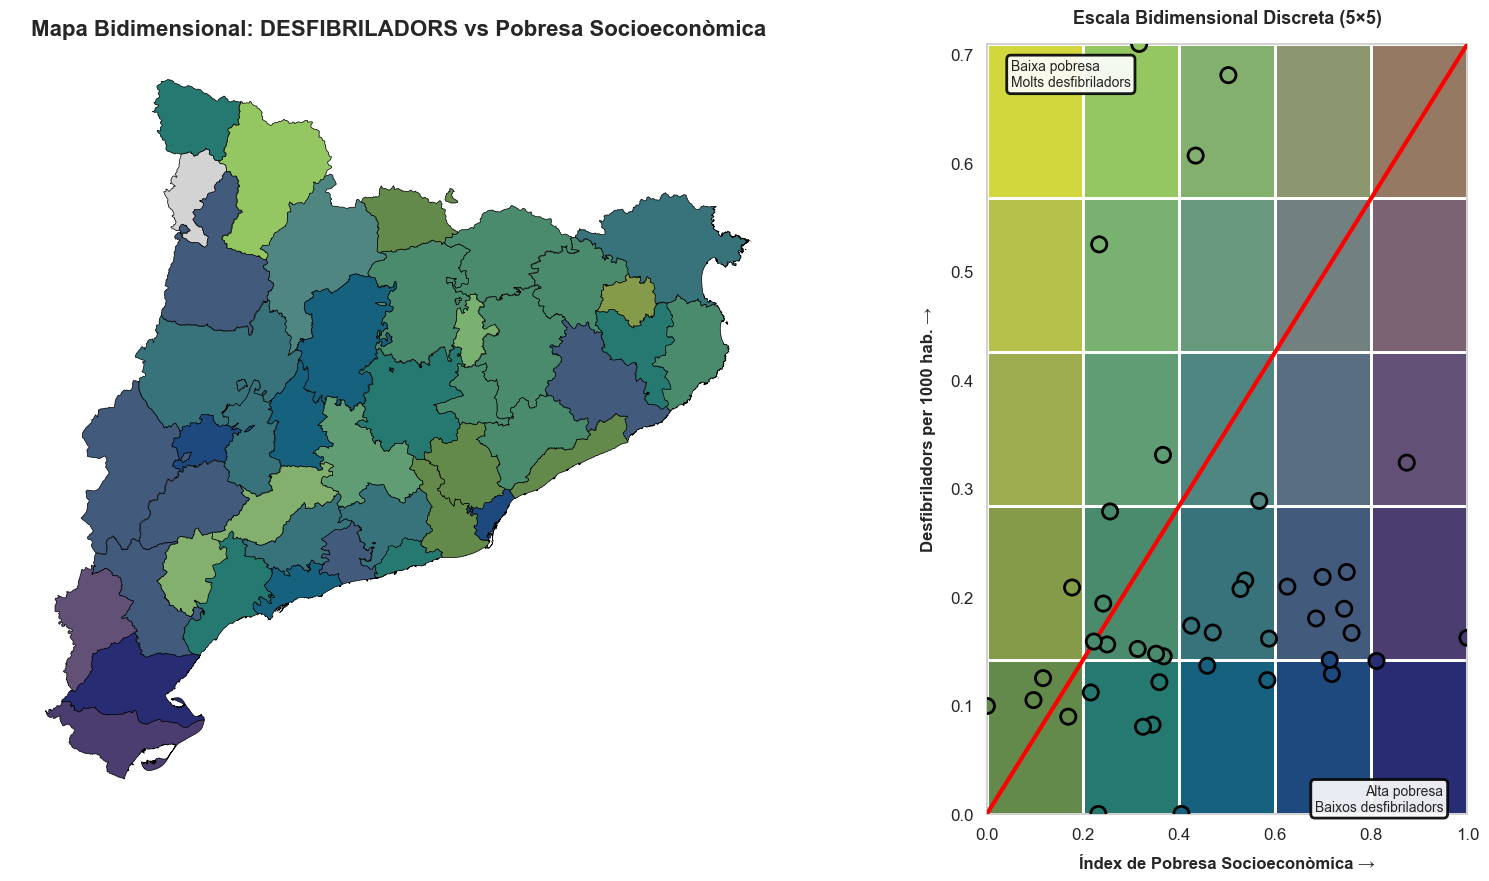


RESUM DESFIBRILADORS
Comarques representades: 42
Rang: 0.000 - 0.709 per 1000 hab.
Mitjana: 0.206
Mediana: 0.162


In [14]:
# ========================================================================
# ANÁLISIS SEPARADO: DESFIBRILADORS
# ========================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

# Preparar datos de DESFIBRILADORS por comarca
desfib_per_comarca = recursos_comarca[['comarca', 'count_desfibriladors']].copy()
desfib_per_comarca = desfib_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
desfib_per_comarca['desfib_per_1000_hab'] = (desfib_per_comarca['count_desfibriladors'] / desfib_per_comarca['poblacio']) * 1000

# Merge con pobreza
datos_desfib = desfib_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# Filtrar outliers
percentil_95_desfib = datos_desfib['desfib_per_1000_hab'].quantile(0.99)
datos_desfib_filtrados = datos_desfib[datos_desfib['desfib_per_1000_hab'] <= percentil_95_desfib].copy()

print(f"DESFIBRILADORS - Percentil 99%: {percentil_95_desfib:.2f}")
print(f"DESFIBRILADORS - Comarques filtrades: {len(datos_desfib_filtrados)} / {len(datos_desfib)}")

# Normalizar índice de pobreza
min_pobreza_d = datos_desfib_filtrados['puntuacio_pobreza'].min()
max_pobreza_d = datos_desfib_filtrados['puntuacio_pobreza'].max()
datos_desfib_filtrados['pobreza_norm'] = (datos_desfib_filtrados['puntuacio_pobreza'] - min_pobreza_d) / (max_pobreza_d - min_pobreza_d)
datos_desfib_filtrados['recursos_sin_norm'] = datos_desfib_filtrados['desfib_per_1000_hab']

# Valores mínimos y máximos
min_recursos_d = datos_desfib_filtrados['recursos_sin_norm'].min()
max_recursos_d = datos_desfib_filtrados['recursos_sin_norm'].max()

# Discretizar
n_bins = 5

datos_desfib_filtrados['pobreza_bin'] = np.floor(datos_desfib_filtrados['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_desfib_filtrados['recursos_bin'] = np.floor(
    (datos_desfib_filtrados['recursos_sin_norm'] - min_recursos_d) / (max_recursos_d - min_recursos_d) * n_bins
).clip(0, n_bins-1).astype(int)

# Crear colormaps
colors_pobreza = plt.cm.viridis_r(np.linspace(0, 1, 256))
cmap_pobreza = LinearSegmentedColormap.from_list('pobreza', colors_pobreza)

colors_recursos = plt.cm.cividis(np.linspace(0, 1, 256))
cmap_recursos = LinearSegmentedColormap.from_list('recursos', colors_recursos)

# Función para calcular colores
def get_discrete_color(pobreza_bin, recursos_bin, n_bins):
    pobreza_val = (pobreza_bin + 0.5) / n_bins
    recursos_val = (recursos_bin + 0.5) / n_bins
    
    col_pob = cmap_pobreza(pobreza_val)[:3]
    col_rec = cmap_recursos(recursos_val)[:3]
    
    return [(col_pob[0] + col_rec[0])/2,
            (col_pob[1] + col_rec[1])/2,
            (col_pob[2] + col_rec[2])/2]

# Aplicar colores
datos_desfib_filtrados['color_rgb'] = datos_desfib_filtrados.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), 
    axis=1
)

# Merge con el mapa de comarcas
comarcas_desfib = comarcas.merge(datos_desfib_filtrados, left_on='NOMCOMAR', right_on='comarca', how='left')

# ========================================================================
# CREAR FIGURA CON 2 SUBPLOTS PARA DESFIBRILADORS
# ========================================================================
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.15)

# SUBPLOT 1: MAPA DESFIBRILADORS
ax_map_d = fig.add_subplot(gs[0])

comarcas_con_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].notna()].copy()
comarcas_sin_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].isna()]

if len(comarcas_sin_color_d) > 0:
    comarcas_sin_color_d.plot(ax=ax_map_d, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_d.iterrows():
    comarcas_con_color_d.loc[[idx]].plot(
        ax=ax_map_d, 
        color=[row['color_rgb']],
        edgecolor='black',
        linewidth=0.5
    )

ax_map_d.set_title('Mapa Bidimensional: DESFIBRILADORS vs Pobresa Socioeconòmica', 
                   fontsize=16, fontweight='bold')
ax_map_d.axis('off')

# SUBPLOT 2: SCATTER PLOT DESFIBRILADORS
ax_scatter_d = fig.add_subplot(gs[1])

# Crear cuadrícula de colores
for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, (j/n_bins)*(max_recursos_d-min_recursos_d)+min_recursos_d), 
                         1/n_bins, (max_recursos_d-min_recursos_d)/n_bins, 
                         facecolor=color, 
                         edgecolor='white', 
                         linewidth=2,
                         alpha=1.0,
                         zorder=1)
        ax_scatter_d.add_patch(rect)

# Líneas de cuadrícula
for i in range(n_bins + 1):
    recursos_val = min_recursos_d + (i/n_bins)*(max_recursos_d-min_recursos_d)
    ax_scatter_d.axhline(recursos_val, color='white', linewidth=2, alpha=0.9, zorder=2)
    ax_scatter_d.axvline(i/n_bins, color='white', linewidth=2, alpha=0.9, zorder=2)

# Scatter points
ax_scatter_d.scatter(
    datos_desfib_filtrados['pobreza_norm'],
    datos_desfib_filtrados['recursos_sin_norm'],
    s=120,
    c=list(datos_desfib_filtrados['color_rgb']),
    edgecolor='black',
    linewidth=2,
    alpha=1.0,
    zorder=10
)

# Línea diagonal
ax_scatter_d.plot([0, 1], [min_recursos_d, max_recursos_d], 
                  color='red', linewidth=3, linestyle='-', zorder=5)

ax_scatter_d.set_xlim(0, 1)
ax_scatter_d.set_ylim(min_recursos_d, max_recursos_d)
ax_scatter_d.set_aspect('auto')
ax_scatter_d.set_xlabel('Índex de Pobresa Socioeconòmica →', fontsize=12, fontweight='bold', labelpad=10)
ax_scatter_d.set_ylabel('Desfibriladors per 1000 hab. →', fontsize=12, fontweight='bold', labelpad=10)
ax_scatter_d.set_title(f'Escala Bidimensional Discreta ({n_bins}×{n_bins})', fontsize=13, fontweight='bold', pad=15)
ax_scatter_d.grid(False)

# Anotaciones
ax_scatter_d.text(0.05, max_recursos_d*0.98, 'Baixa pobresa\nMolts desfibriladors', 
                  fontsize=10, ha='left', va='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))
ax_scatter_d.text(0.95, min_recursos_d*1.02, 'Alta pobresa\nBaixos desfibriladors', 
                  fontsize=10, ha='right', va='bottom',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

# Estadísticas
print(f"\n{'='*70}")
print(f"RESUM DESFIBRILADORS")
print(f"{'='*70}")
print(f"Comarques representades: {len(datos_desfib_filtrados)}")
print(f"Rang: {min_recursos_d:.3f} - {max_recursos_d:.3f} per 1000 hab.")
print(f"Mitjana: {datos_desfib_filtrados['recursos_sin_norm'].mean():.3f}")
print(f"Mediana: {datos_desfib_filtrados['recursos_sin_norm'].median():.3f}")

HOSPITALS - Percentil 99%: 3.86
HOSPITALS - Comarques filtrades: 42 / 43


C:\Users\German\AppData\Local\Temp\ipykernel_12628\3052870448.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


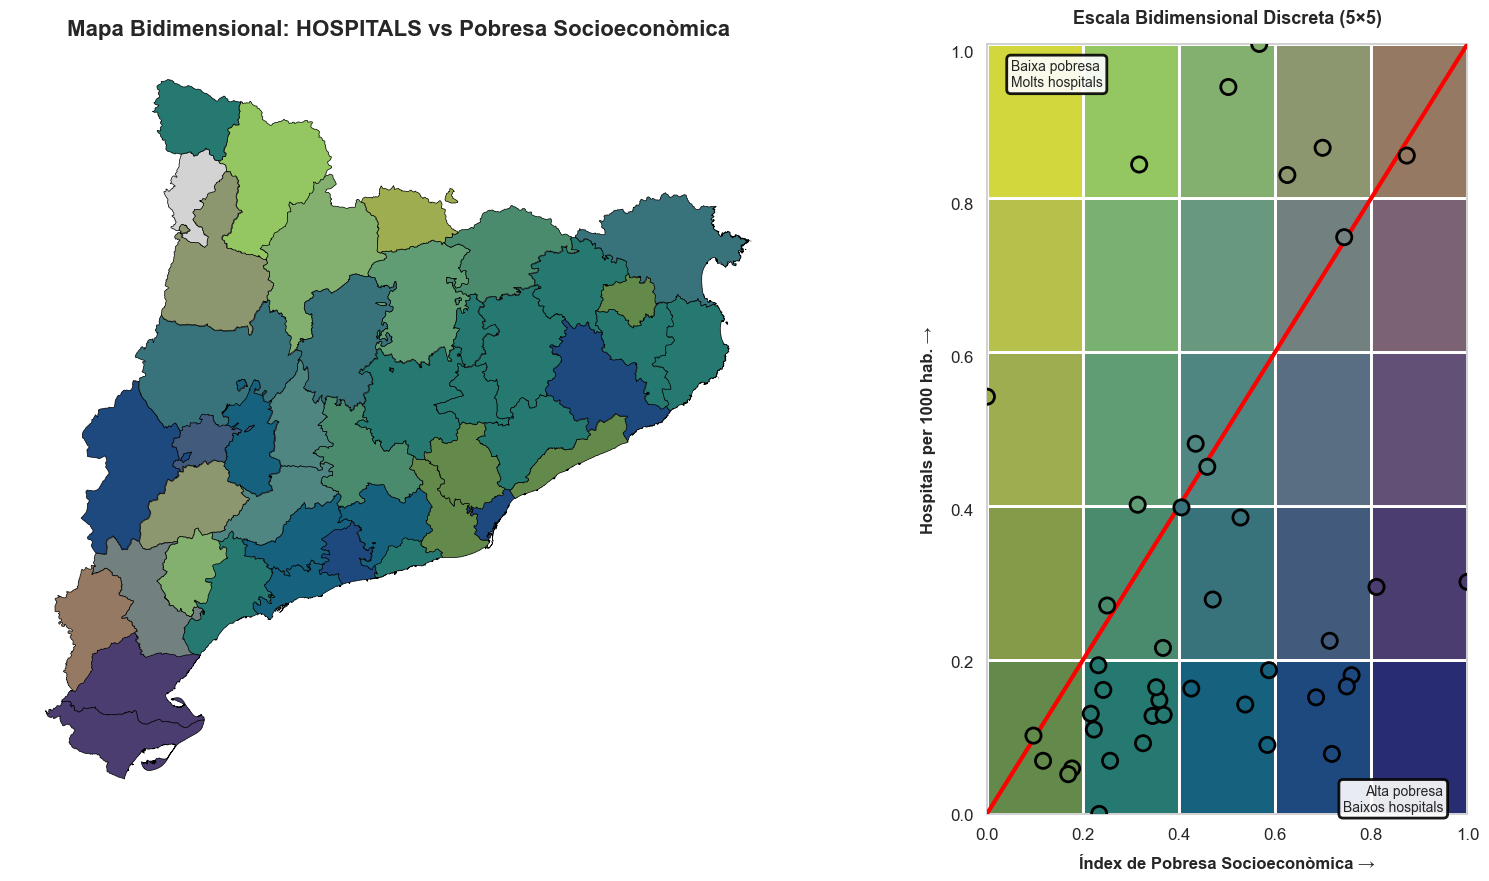


RESUM HOSPITALS
Comarques representades: 42
Rang: 0.000 - 1.009 per 1000 hab.
Mitjana: 0.315
Mediana: 0.185


In [15]:
# ========================================================================
# ANÁLISIS SEPARADO: HOSPITALS
# ========================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

# Preparar datos de HOSPITALES por comarca
hospi_per_comarca = recursos_comarca[['comarca', 'count_hospitals']].copy()
hospi_per_comarca = hospi_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
hospi_per_comarca['hospi_per_1000_hab'] = (hospi_per_comarca['count_hospitals'] / hospi_per_comarca['poblacio']) * 1000

# Merge con pobreza
datos_hospi = hospi_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# Filtrar outliers
percentil_95_hospi = datos_hospi['hospi_per_1000_hab'].quantile(0.99)
datos_hospi_filtrados = datos_hospi[datos_hospi['hospi_per_1000_hab'] <= percentil_95_hospi].copy()

print(f"HOSPITALS - Percentil 99%: {percentil_95_hospi:.2f}")
print(f"HOSPITALS - Comarques filtrades: {len(datos_hospi_filtrados)} / {len(datos_hospi)}")

# Normalizar índice de pobreza
min_pobreza_h = datos_hospi_filtrados['puntuacio_pobreza'].min()
max_pobreza_h = datos_hospi_filtrados['puntuacio_pobreza'].max()
datos_hospi_filtrados['pobreza_norm'] = (datos_hospi_filtrados['puntuacio_pobreza'] - min_pobreza_h) / (max_pobreza_h - min_pobreza_h)
datos_hospi_filtrados['recursos_sin_norm'] = datos_hospi_filtrados['hospi_per_1000_hab']

# Valores mínimos y máximos
min_recursos_h = datos_hospi_filtrados['recursos_sin_norm'].min()
max_recursos_h = datos_hospi_filtrados['recursos_sin_norm'].max()

# Discretizar
n_bins = 5

datos_hospi_filtrados['pobreza_bin'] = np.floor(datos_hospi_filtrados['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_hospi_filtrados['recursos_bin'] = np.floor(
    (datos_hospi_filtrados['recursos_sin_norm'] - min_recursos_h) / (max_recursos_h - min_recursos_h) * n_bins
).clip(0, n_bins-1).astype(int)

# Crear colormaps
colors_pobreza = plt.cm.viridis_r(np.linspace(0, 1, 256))
cmap_pobreza = LinearSegmentedColormap.from_list('pobreza', colors_pobreza)

colors_recursos = plt.cm.cividis(np.linspace(0, 1, 256))
cmap_recursos = LinearSegmentedColormap.from_list('recursos', colors_recursos)

# Función para calcular colores
def get_discrete_color(pobreza_bin, recursos_bin, n_bins):
    pobreza_val = (pobreza_bin + 0.5) / n_bins
    recursos_val = (recursos_bin + 0.5) / n_bins
    
    col_pob = cmap_pobreza(pobreza_val)[:3]
    col_rec = cmap_recursos(recursos_val)[:3]
    
    return [(col_pob[0] + col_rec[0])/2,
            (col_pob[1] + col_rec[1])/2,
            (col_pob[2] + col_rec[2])/2]

# Aplicar colores
datos_hospi_filtrados['color_rgb'] = datos_hospi_filtrados.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), 
    axis=1
)

# Merge con el mapa de comarcas
comarcas_hospi = comarcas.merge(datos_hospi_filtrados, left_on='NOMCOMAR', right_on='comarca', how='left')

# ========================================================================
# CREAR FIGURA CON 2 SUBPLOTS PARA HOSPITALS
# ========================================================================
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.15)

# SUBPLOT 1: MAPA HOSPITALS
ax_map_h = fig.add_subplot(gs[0])

comarcas_con_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].notna()].copy()
comarcas_sin_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].isna()]

if len(comarcas_sin_color_h) > 0:
    comarcas_sin_color_h.plot(ax=ax_map_h, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_h.iterrows():
    comarcas_con_color_h.loc[[idx]].plot(
        ax=ax_map_h, 
        color=[row['color_rgb']],
        edgecolor='black',
        linewidth=0.5
    )

ax_map_h.set_title('Mapa Bidimensional: HOSPITALS vs Pobresa Socioeconòmica', 
                   fontsize=16, fontweight='bold')
ax_map_h.axis('off')

# SUBPLOT 2: SCATTER PLOT HOSPITALS
ax_scatter_h = fig.add_subplot(gs[1])

# Crear cuadrícula de colores
for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, (j/n_bins)*(max_recursos_h-min_recursos_h)+min_recursos_h), 
                         1/n_bins, (max_recursos_h-min_recursos_h)/n_bins, 
                         facecolor=color, 
                         edgecolor='white', 
                         linewidth=2,
                         alpha=1.0,
                         zorder=1)
        ax_scatter_h.add_patch(rect)

# Líneas de cuadrícula
for i in range(n_bins + 1):
    recursos_val = min_recursos_h + (i/n_bins)*(max_recursos_h-min_recursos_h)
    ax_scatter_h.axhline(recursos_val, color='white', linewidth=2, alpha=0.9, zorder=2)
    ax_scatter_h.axvline(i/n_bins, color='white', linewidth=2, alpha=0.9, zorder=2)

# Scatter points
ax_scatter_h.scatter(
    datos_hospi_filtrados['pobreza_norm'],
    datos_hospi_filtrados['recursos_sin_norm'],
    s=120,
    c=list(datos_hospi_filtrados['color_rgb']),
    edgecolor='black',
    linewidth=2,
    alpha=1.0,
    zorder=10
)

# Línea diagonal
ax_scatter_h.plot([0, 1], [min_recursos_h, max_recursos_h], 
                  color='red', linewidth=3, linestyle='-', zorder=5)

ax_scatter_h.set_xlim(0, 1)
ax_scatter_h.set_ylim(min_recursos_h, max_recursos_h)
ax_scatter_h.set_aspect('auto')
ax_scatter_h.set_xlabel('Índex de Pobresa Socioeconòmica →', fontsize=12, fontweight='bold', labelpad=10)
ax_scatter_h.set_ylabel('Hospitals per 1000 hab. →', fontsize=12, fontweight='bold', labelpad=10)
ax_scatter_h.set_title(f'Escala Bidimensional Discreta ({n_bins}×{n_bins})', fontsize=13, fontweight='bold', pad=15)
ax_scatter_h.grid(False)

# Anotaciones
ax_scatter_h.text(0.05, max_recursos_h*0.98, 'Baixa pobresa\nMolts hospitals', 
                  fontsize=10, ha='left', va='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))
ax_scatter_h.text(0.95, min_recursos_h*1.02, 'Alta pobresa\nBaixos hospitals', 
                  fontsize=10, ha='right', va='bottom',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

# Estadísticas
print(f"\n{'='*70}")
print(f"RESUM HOSPITALS")
print(f"{'='*70}")
print(f"Comarques representades: {len(datos_hospi_filtrados)}")
print(f"Rang: {min_recursos_h:.3f} - {max_recursos_h:.3f} per 1000 hab.")
print(f"Mitjana: {datos_hospi_filtrados['recursos_sin_norm'].mean():.3f}")
print(f"Mediana: {datos_hospi_filtrados['recursos_sin_norm'].median():.3f}")